In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copy Playing Card Zip file to colab
import os
import shutil

In [3]:
shutil.copy('/content/drive/My Drive/Playing Card.zip', '/content')

'/content/Playing Card.zip'

In [4]:
# importing required modules 
from zipfile import ZipFile 

# specifying the zip file name 
file_name = "/content/Playing Card.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
	# printing all the contents of the zip file 
	# zip.printdir() 

	# extracting all the files 
	print('Extracting all the files now...') 
	zip.extractall() 
	print('Done!') 


Extracting all the files now...
Done!


In [5]:
cd /content/Playing Card

/content/Playing Card


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

import numpy as np
import os
import copy
import tqdm
from PIL import Image

In [0]:
train_dir = '/content/Playing Card/train'
test_dir = '/content/Playing Card/test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [0]:
class CardDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'king' in self.file_list[0]:
              self.label = 0
            elif 'ace' in self.file_list[0]:
              self.label = 1
            elif 'nine' in self.file_list[0]:
              self.label = 2
            elif 'jack' in self.file_list[0]:
              self.label = 3
            elif 'ten' in self.file_list[0]:
              self.label = 4
            else:
                self.label = 5
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [0]:
# define transform
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

In [0]:
king_files = [tf for tf in train_files if 'king' in tf]
ace_files = [tf for tf in train_files if 'ace' in tf]
nine_files = [tf for tf in train_files if 'nine' in tf]
ten_files = [tf for tf in train_files if 'ten' in tf]
jack_files = [tf for tf in train_files if 'jack' in tf]
queen_files = [tf for tf in train_files if 'queen' in tf]

In [0]:
kings = CardDataset(king_files, train_dir, transform = data_transform)
aces = CardDataset(ace_files, train_dir, transform = data_transform)
nines = CardDataset(nine_files, train_dir, transform = data_transform)
tens = CardDataset(ten_files, train_dir, transform = data_transform)
jacks = CardDataset(jack_files, train_dir, transform = data_transform)
queens = CardDataset(queen_files, train_dir, transform = data_transform)

In [0]:
Cards = ConcatDataset([kings, aces, nines, tens, jacks, queens])

In [0]:
# split into train and validation set
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(Cards)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(Cards, batch_size=32,
    sampler=train_sampler, num_workers=4)
valid_loader = torch.utils.data.DataLoader(Cards, batch_size=32, 
    sampler=valid_sampler, num_workers=4)

In [0]:
# specify the images classes
classes = ['king', 'ace', 'nine', 'jack', 'ten', 'queen']

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

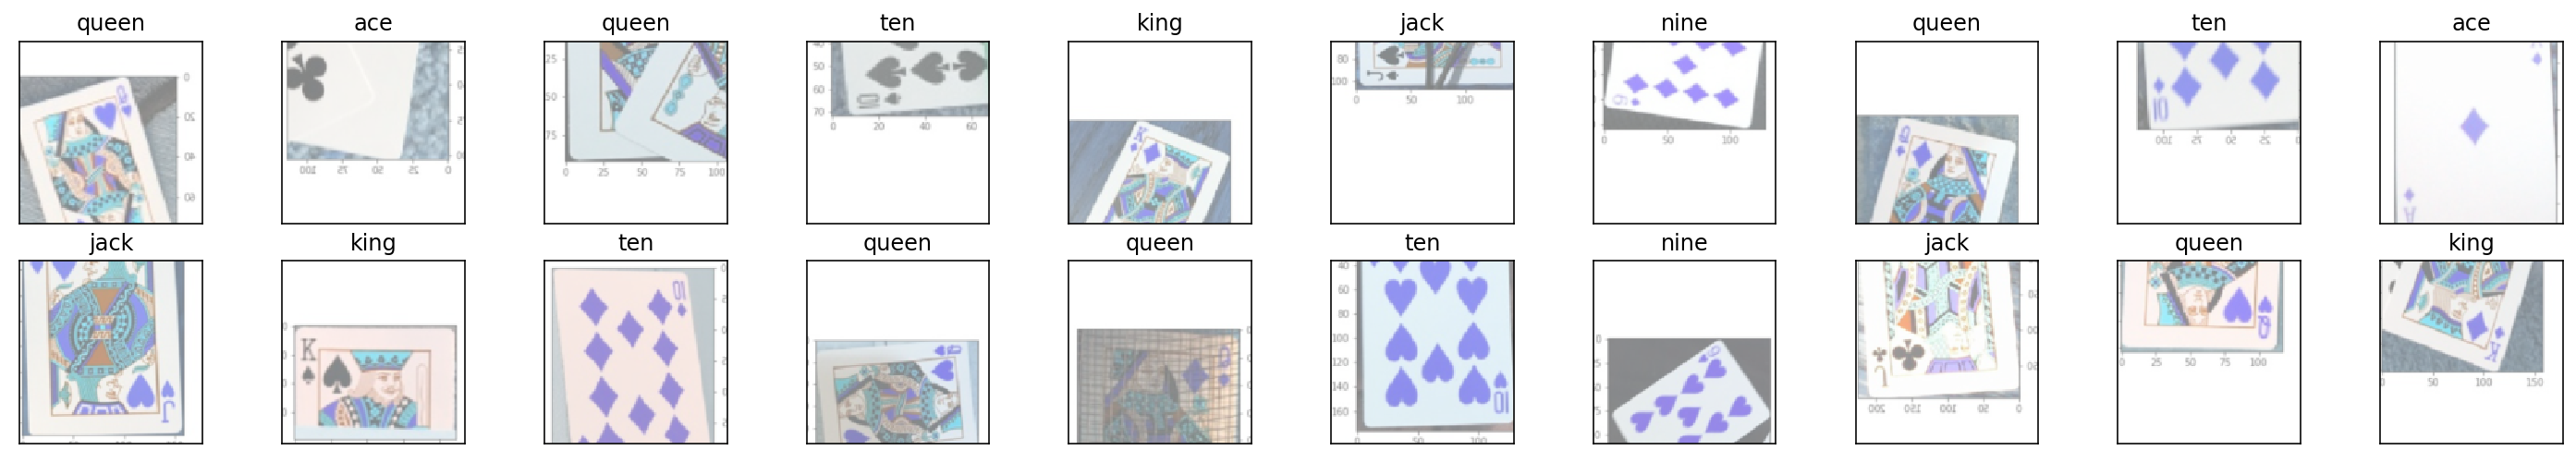

In [17]:
import numpy as np
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

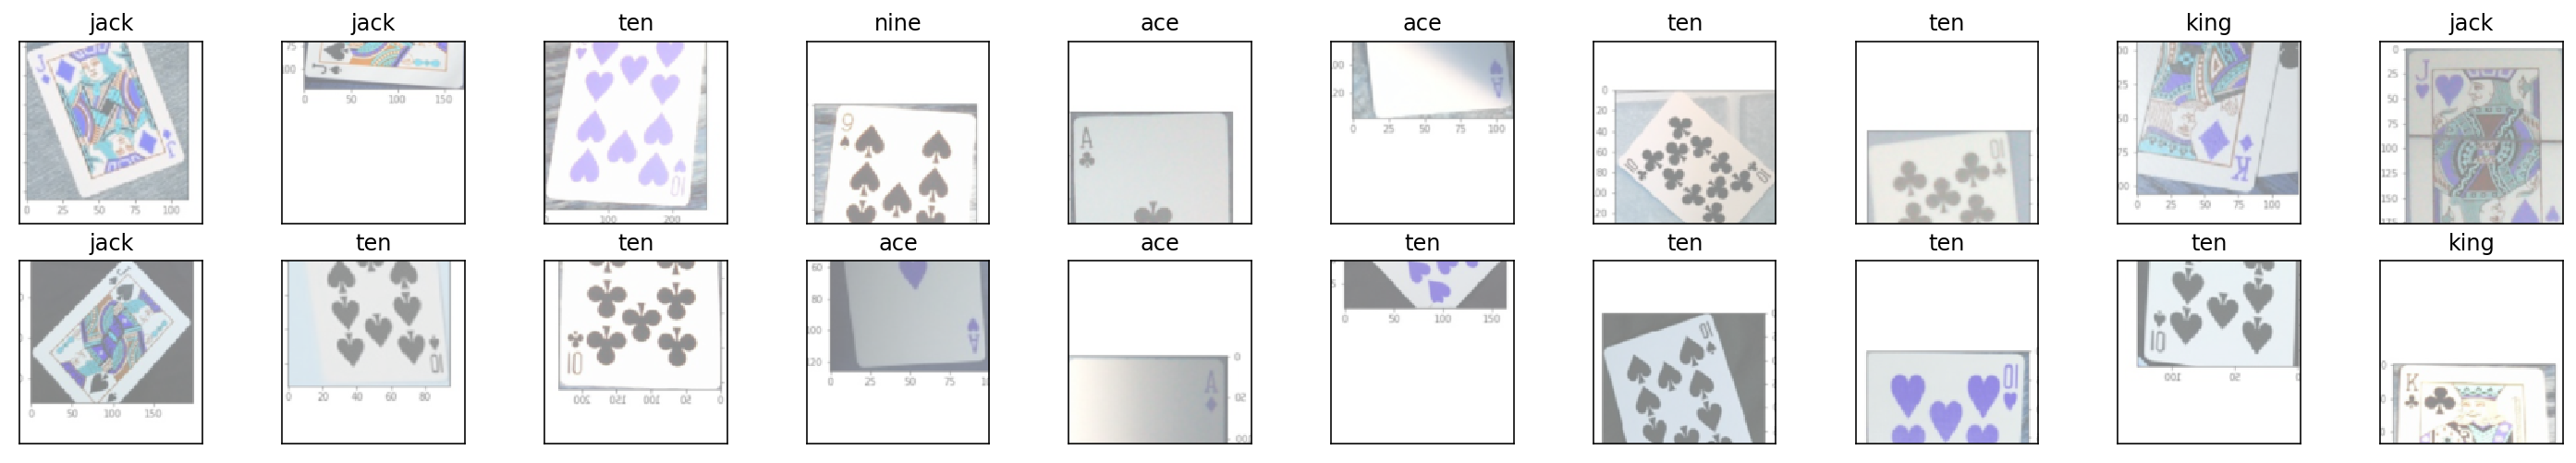

In [18]:
import numpy as np
# obtain one batch of validation images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# use pretrained model
from torchvision import models
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

In [20]:
# check, if GPU is available or device or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
# Load DenseNet Model
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 26.7MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:
# above pretrained model have 1000 output layers but we want only 2
# Freeze parameters so we don't backprop through them
for param in model.parameters():
  param.requires_grad = False
  
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 256)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.2)),
                          ('fc3', nn.Linear(256, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [33]:
# pass model to GPU
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [36]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.610162 	Validation Loss: 1.037617
Validation loss decreased (inf --> 1.037617).  Saving model ...
Epoch: 2 	Training Loss: 1.019586 	Validation Loss: 0.880721
Validation loss decreased (1.037617 --> 0.880721).  Saving model ...
Epoch: 3 	Training Loss: 0.756829 	Validation Loss: 0.665222
Validation loss decreased (0.880721 --> 0.665222).  Saving model ...
Epoch: 4 	Training Loss: 0.746414 	Validation Loss: 0.620027
Validation loss decreased (0.665222 --> 0.620027).  Saving model ...
Epoch: 5 	Training Loss: 0.662968 	Validation Loss: 0.803030
Epoch: 6 	Training Loss: 0.635851 	Validation Loss: 0.650429
Epoch: 7 	Training Loss: 0.594181 	Validation Loss: 0.675357
Epoch: 8 	Training Loss: 0.645190 	Validation Loss: 0.552075
Validation loss decreased (0.620027 --> 0.552075).  Saving model ...
Epoch: 9 	Training Loss: 0.557011 	Validation Loss: 0.727591
Epoch: 10 	Training Loss: 0.566218 	Validation Loss: 0.679466
Epoch: 11 	Training Loss: 0.502087 	Validation Lo

In [37]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [0]:
# test transform
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [0]:
# load test data
testset = CardDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

In [0]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
  with torch.no_grad():
    x = x.to(device)
    output = model(x)
    pred = torch.argmax(output, dim=1)
    fn_list += [n[:-4] for n in fn]
    pred_list += [p.item() for p in pred]

In [0]:
import pandas as pd

In [48]:
submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.head()

,id,label
0,130-king-IMG_2662,0
1,42-ace-IMG_2476,3
2,82-ace-IMG_2580,1
3,141-queen-IMG_2686,5
4,101-jack-IMG_2594,5


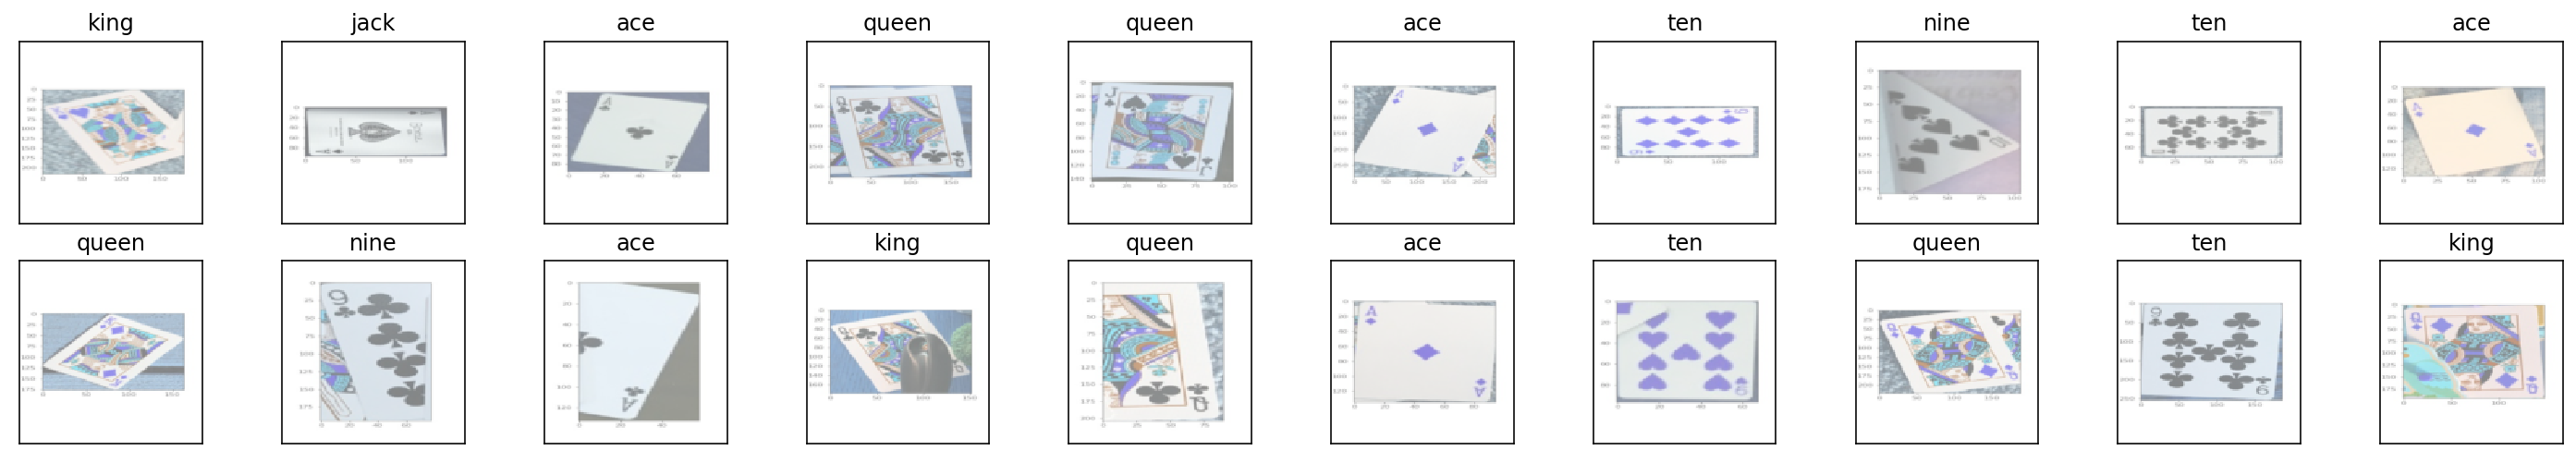

In [49]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

labels = pred_list
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])